In [2]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline 

In [101]:
# load data
with open('./youtube_train_data.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train_data, train_labels = u.load()

In [102]:
train_data = train_data.astype(np.float32)

In [5]:
# normalize the training data over each image
train_data_normalized -= np.mean(train_data, axis=(2, 3, 4), keepdims=True)
train_data_normalized /= np.std(train_data, axis=(2, 3, 4), keepdims=True)

In [6]:
num_data = len(train_data)
np.random.seed(2019)
ind = np.random.permutation(num_data)

split_rate = 0.8
num_train = int(split_rate * num_data)

X_train = train_data_normalized[ind[:num_train]]
Y_train = train_labels[ind[:num_train]]

X_valid = train_data_normalized[ind[num_train+1:]]
Y_valid = train_data[ind[num_train+1:]]

In [273]:
lr = 0.01
batch_size = 10
seq_length = 10
num_units = 100 # num LSTM hidden units

In [274]:
tf.reset_default_graph()

x = tf.placeholder(shape=[None, 10, 64, 64, 3], dtype=tf.float32)
y = tf.placeholder(shape=[None, 10, 7, 2], dtype=tf.float32)

In [275]:
cnn_weights = {
    'w1': tf.Variable(tf.random_normal([5,5,3,16], stddev = 0.1, name='w1')),
    'w2': tf.Variable(tf.random_normal([5,5,16,32], stddev = 0.1, name='w2')), 
    'w3': tf.Variable(tf.random_normal([3,3,32,64], stddev = 0.1, name='w3'))
}

cnn_biases = {
    'b1': tf.Variable(tf.random_normal([16],stddev = 0.1, name='b1')),
    'b2': tf.Variable(tf.random_normal([32],stddev = 0.1, name='b2')),
    'b3': tf.Variable(tf.random_normal([64],stddev = 0.1, name='b3'))
}

In [276]:
def CNN(x, w, b):
    conv1 = tf.nn.conv2d(x, filter=w['w1'],strides=[1,1,1,1], padding='SAME') # [None,64,64,6]
    conv1 = tf.nn.bias_add(conv1, b['b1'])
    acti1 = tf.nn.relu(conv1)
    pool1 = tf.nn.max_pool(acti1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # [None,32,32,6]
    c_nb1 = tf.layers.batch_normalization(pool1)

    conv2 = tf.nn.conv2d(c_nb1, filter=w['w2'],strides=[1,1,1,1], padding='SAME') # [None,32,32,10]
    conv2 = tf.nn.bias_add(conv2, b['b2'])
    acti2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(acti2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # [None,16,16,10]
    c_nb2 = tf.layers.batch_normalization(pool2)
    
    conv3 = tf.nn.conv2d(c_nb2, filter=w['w3'], strides=[1,1,1,1], padding='SAME') # [None,16,16,16]
    conv3 = tf.nn.bias_add(conv3, b['b3'])
    acti3 = tf.nn.relu(conv3)
    pool3 = tf.nn.max_pool(acti3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # [None,8,8,16]
    c_nb3 = tf.layers.batch_normalization(pool3)

    fc1 = tf.contrib.layers.flatten(c_nb3)
    
    return fc1

In [277]:
def LSTM(rnn_input):
    lstm_cell = tf.keras.layers.LSTMCell(num_units)
    h_val, h_state = tf.nn.dynamic_rnn(lstm_cell, rnn_input, dtype=tf.float32)
    
    return h_val, h_state

In [278]:
f_weight = tf.Variable(tf.random.normal([num_units, 14], stddev = 0.1))
f_bias = tf.Variable(tf.random.normal([14], stddev = 0.1))

In [279]:
fc = tf.reshape(CNN(tf.reshape(x, [-1,64,64,3]), cnn_weights, cnn_biases), [-1,10,8*8*64])
h_val, _ = LSTM(fc)

In [280]:
# collection of all the final output
final_output = tf.zeros(shape=[batch_size, 0, 14])
for i in np.arange(seq_length):
    temp = tf.reshape(h_val[:, i, :], [-1, num_units])
    output = tf.matmul(temp, f_weight) + f_bias
    output = tf.reshape(output, [-1, 1, 14])
    final_output = tf.concat([final_output, output], axis=1)

In [281]:
loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=tf.reshape(y,[-1,10,14]), predictions=final_output))

In [282]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [283]:
predict_op = tf.reshape(final_output, [-1,10,7,2])

In [260]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(300):
        X_batch = X_train[:batch_size]
        Y_batch = Y_train[:batch_size]
        
        _, l, pred = sess.run([optimizer, loss, predict_op], feed_dict={x:X_batch, y:Y_batch})
        
        if epoch % 20 == 0:
            print('epoch: {}'.format(epoch))
            print('loss: {}'.format(l))
            print('pred: {}'.format(pred[1][0]))
    #         print('GT: {}'.format(Y_batch[0][0]))
        
#         plt.imshow((X_batch[0][0]-np.min(X_batch[0][0]))/np.max(X_batch[0][0]))
#         plt.show()

epoch: 0
loss: 1075.162353515625
pred: [[ 0.23123364  0.10666774]
 [-0.02159846  0.03882208]
 [-0.43560186 -0.10632291]
 [-0.19698766 -0.383236  ]
 [-0.03442141  0.11160627]
 [-0.08720686 -0.2900797 ]
 [ 0.09294343  0.06739204]]
epoch: 20
loss: 599.5275268554688
pred: [[7.322566  7.2678127]
 [7.465975  7.336941 ]
 [7.6187816 7.0885487]
 [7.403099  6.8142858]
 [7.477945  6.9910536]
 [7.248806  6.36547  ]
 [7.174323  6.5512924]]


KeyboardInterrupt: 

In [284]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(400):
    X_batch = X_train[:batch_size]
    Y_batch = Y_train[:batch_size]

    _, l, pred = sess.run([optimizer, loss, predict_op], feed_dict={x:X_batch, y:Y_batch})

    if epoch % 20 == 0:
        print('epoch: {}'.format(epoch))
        print('loss: {}'.format(l))
#         print('pred: {}'.format(pred[1][0]))
#         print('GT: {}'.format(Y_batch[0][0]))

epoch: 0
loss: 1095.7098388671875
epoch: 20
loss: 608.8097534179688
epoch: 40
loss: 326.8182067871094
epoch: 60
loss: 173.01829528808594
epoch: 80
loss: 103.53776550292969
epoch: 100
loss: 74.54568481445312
epoch: 120
loss: 63.637088775634766
epoch: 140
loss: 59.982479095458984
epoch: 160
loss: 58.857845306396484
epoch: 180
loss: 58.48249816894531
epoch: 200
loss: 58.295654296875
epoch: 220
loss: 58.150917053222656
epoch: 240
loss: 58.01679611206055
epoch: 260
loss: 57.88766860961914
epoch: 280
loss: 57.76258850097656
epoch: 300
loss: 57.641326904296875
epoch: 320
loss: 57.5236930847168
epoch: 340
loss: 57.40951919555664
epoch: 360
loss: 57.2986946105957
epoch: 380
loss: 57.19104766845703


In [327]:
xx = 2
pred = sess.run(predict_op, feed_dict={x: X_train[xx:xx+batch_size]})

In [328]:
zz = 4
print(pred[zz][0])
# print(Y_train[zz][0])
print(pred[zz][0] - Y_train[zz][0])

[[25.058146 13.98947 ]
 [20.478634 28.89505 ]
 [30.127571 30.4534  ]
 [17.912397 31.238733]
 [31.758581 32.25976 ]
 [20.574171 20.98079 ]
 [29.44961  20.984308]]
[[ -4.1420174  -5.075407 ]
 [ -5.8398075 -16.790306 ]
 [ -4.491947  -14.84948  ]
 [ -4.406044  -12.304747 ]
 [ -5.140505   -9.447823 ]
 [ -4.1098614  -7.646042 ]
 [ -5.25593    -8.177992 ]]


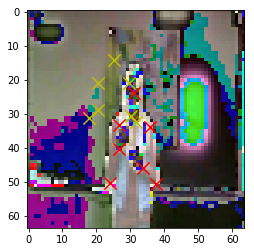

In [329]:
plt.imshow((X_train[xx][0] - np.min(X_train[xx][0]))/np.max(X_train[xx][0]))
for i in range(7):
    plt.scatter(Y_train[xx][0][i][0], Y_train[xx][0][i][1], marker='x',s=150,c='r')
    plt.scatter(pred[0][0][i][0], pred[0][0][i][1], marker='x',s=150,c='y')

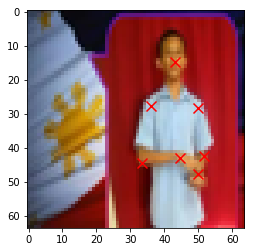

In [316]:
j = 4
k = 3400
plt.imshow((train_data[k][j] + 256)/255.)
for i in range(7):
    plt.scatter(train_labels[k][j][i][0], train_labels[k][j][i][1], marker='x', s=100, c='r')

In [125]:
train_labels[0][2]

array([[34.162395, 21.559414],
       [22.119383, 41.18453 ],
       [34.678524, 47.446236],
       [21.603254, 50.653454],
       [39.925835, 51.340714],
       [26.205404, 33.930107],
       [38.033363, 34.617367]], dtype=float32)